In [121]:
# import packages 
import json
import pandas as pd
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from pandasql import sqldf
import sqlite3
import re 

### Sales Data - Integration and Cleanup

There were two main issues identified during the integration:
1. some objects saved as strings and
2. some nested objects whith non-busines-name parents (today, fine, etc)

To cover these two issues I created a function called func_to_dict() which convert the json to a dictionary, in th
right format and with the correct data only.

In [122]:
# read sales data from json file
with open('sales_data.json') as f:
    sales = json.load(f) 

In [123]:
### two main issues identified: (1) some objects saved as strings and (2) some nested objects 
# whith non-busines-name parents
def func_to_dict(source, target1, target2):
    for el in source:
        if isinstance(el, dict) and list(el.keys())[0] == 'SaleID':  #following the pattern for the correct objects
            target1.append(el)                                       # that'SaleID' is the first key in the object
        elif isinstance(el, dict) and list(el.keys())[0] != 'SaleID': #if condition not true, we get the inner
            target2.append(el[list(el.keys())[0]])                    #object of the nested object
        elif isinstance(el, str):
            res = json.loads(el)
            target1.append(res)


In [124]:
#Calling the function twice, because we have only one inner and outer object
list1= []
list2= []
list3= []
func_to_dict(sales, list1, list2); 
func_to_dict(list2, list1, list2);

In [125]:
#Convert the dictionary to a pandas dataframe
sales_data = pd.DataFrame.from_dict(list1)
sales_data.head(5)

,SaleID,ProductID,CustomerID,Quantity,TotalAmount,SaleDate
0,5083,343.0,9320,9,1431,2023-06-19
1,6690,463.0,8458,6,648,2020-05-15
2,8362,750.0,8226,1,172,2022-11-03
3,6412,419.0,3217,9,1665,2023-06-17
4,1721,840.0,7811,8,800,2022-04-21


##### Data Quality Check - Sales

In [126]:
# From here we can see that SaleIDs are all unique and we do not have any null SaleID.
# But from the other side we have null ProductID, which seems like an issue, becasue a sale should be 
#related to at least a product.
print(sales_data.shape)
print(sales_data.nunique())
print(sales_data.info())
print(sales_data.isnull().sum())

(2983, 6)
SaleID         2983
ProductID       201
CustomerID      401
Quantity         10
TotalAmount     762
SaleDate       1178
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2983 entries, 0 to 2982
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SaleID       2983 non-null   int64  
 1   ProductID    2944 non-null   float64
 2   CustomerID   2983 non-null   int64  
 3   Quantity     2983 non-null   int64  
 4   TotalAmount  2983 non-null   int64  
 5   SaleDate     2983 non-null   object 
dtypes: float64(1), int64(4), object(1)
memory usage: 140.0+ KB
None
SaleID          0
ProductID      39
CustomerID      0
Quantity        0
TotalAmount     0
SaleDate        0
dtype: int64


In [127]:
#39 null products id-s. 
#As we cannot analyze the sales realted to this product, we drop them for now. In a real case, we would ask data
#providers to either complete the empty ProductIDs or give a business explanation of the "sales without products".

sales_data = sales_data.dropna(axis=0)
sales_data.isnull().sum()

SaleID         0
ProductID      0
CustomerID     0
Quantity       0
TotalAmount    0
SaleDate       0
dtype: int64

In [128]:
#ProductID and SalesDate datatype do not seem correct, so we convert ProductID to int and SalesDate to datetime.
sales_data['ProductID']  = sales_data['ProductID'] .astype('int64')
sales_data['SaleDate'] = sales_data['SaleDate'].astype('datetime64[ns]')
print(sales_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2944 entries, 0 to 2982
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   SaleID       2944 non-null   int64         
 1   ProductID    2944 non-null   int64         
 2   CustomerID   2944 non-null   int64         
 3   Quantity     2944 non-null   int64         
 4   TotalAmount  2944 non-null   int64         
 5   SaleDate     2944 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5)
memory usage: 161.0 KB
None


In [129]:
#Another check we will do is to see if there are negative TotalAmount.
#We have 52 sales with negative amount. This can either be a data quality issue or it might have a business
#meaning, like for example returned products. For now let us suppose it is the second case.
sales_data.TotalAmount[sales_data.TotalAmount<0].count()

52

### Customers - Integration and Cleanup


In [130]:
#there seem not to be any issue with loading the data from json file to the pandas dataframe
customers = pd.read_json('customers.json')
customers.head(5)

,CustomerID,Name,Region,SignUpDate,Email,LoyaltyPoints
0,8220,Brandon Bender,North,2023-08-14,mirandajoel@example.org,129
1,6670,Kari Ford,North,2020-03-02,brucewesley@example.org,528
2,9865,Andrea Leonard,None,2020-11-26,newmantimothy@example.com,2182
3,5082,Christina Mcdowell,None,2022-12-07,smithdouglas@example.com,3091
4,3737,Kevin Martin,South,2019-11-02,pinedakelli@example.net,1156


##### Data Quality Check - Customers

In [131]:
## same checks we did for sales dataframe
#We see that the CustomerIDs are unique in the dataframe. We have null values in the "Region" and "SignUpDate". 
#In this case let supose that those attribute can be Null. It is better not to delete the records, as those
# customers can be related to some sales. Best solution is to ask business users to complete the dataset.

print(customers.shape)
print(customers.nunique())
print(customers.info())
print(customers.isnull().sum())

(400, 6)
CustomerID       400
Name             400
Region             4
SignUpDate       306
Email            400
LoyaltyPoints    382
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     400 non-null    int64 
 1   Name           400 non-null    object
 2   Region         312 non-null    object
 3   SignUpDate     333 non-null    object
 4   Email          400 non-null    object
 5   LoyaltyPoints  400 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 18.9+ KB
None
CustomerID        0
Name              0
Region           88
SignUpDate       67
Email             0
LoyaltyPoints     0
dtype: int64


In [132]:
#Datatype convertion
customers['SignUpDate'] = customers['SignUpDate'].astype('datetime64[ns]')
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustomerID     400 non-null    int64         
 1   Name           400 non-null    object        
 2   Region         312 non-null    object        
 3   SignUpDate     333 non-null    datetime64[ns]
 4   Email          400 non-null    object        
 5   LoyaltyPoints  400 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 18.9+ KB
None


In [133]:
## validate emails: No Invalid emails
def email_validation (email):  
    if re.match(r"[^@]+@[^@]+\.[^@]+", email):  
        return 'Valid'
    else:
        return 'Invalid'

for index, row in customers.iterrows():
    res = email_validation (row['Email'])
    if res == 'Invalid':
        print(res)

### Product - Integration and Cleanup

In [134]:
# Read and load the product data from csv file to pandas dataframe
products = pd.read_csv ('products.csv')
products.head(5)

,ProductID,ProductName,Category,Price,Supplier
0,207,,Puzzle,64,Brown-Garcia
1,732,Joseph,RC Toy,170,Ortiz Inc
2,463,Jacob,RC Toy,108,Hinton-Patterson
3,163,Shawn,Action Figure,107,"Rios, Cannon and Wheeler"
4,255,Daniel,Puzzle,163,Summers LLC


##### Data Quality Check - Products

In [135]:
## products - We see that we have 200 unique ProductIDs, but one extra record
# no other issues identified

print(products.shape)
print(products.nunique())
print(products.info())
print(products.isnull().sum())

(201, 5)
ProductID      200
ProductName    153
Category         6
Price          128
Supplier       199
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProductID    201 non-null    int64 
 1   ProductName  201 non-null    object
 2   Category     201 non-null    object
 3   Price        201 non-null    int64 
 4   Supplier     201 non-null    object
dtypes: int64(2), object(3)
memory usage: 8.0+ KB
None
ProductID      0
ProductName    0
Category       0
Price          0
Supplier       0
dtype: int64


In [136]:
#Checkin the rows with the similar ProductID. In this case it look like there is a duplicated record,
#so we remove that
prd = products.ProductID.value_counts()
for i in prd.index:
    if prd[i] > 1:
        print(i)
        
products.loc[products['ProductID'] == 254]

254


,ProductID,ProductName,Category,Price,Supplier
121,254,,Action Figure,109,Price-Little
200,254,,Action Figure,109,Price-Little


In [137]:
#drop duplicated records
products.drop_duplicates(subset = 'ProductID', inplace = True)
products.shape

(200, 5)

Before moving to the next step, we do another data integrity test to check it all forign keys from sales_data can be found in the possible dimension tables (customer product). From the results below, we can see that we have cases. This data integrity issues will lead to wronf results during analysis so the best solution is to complete the missing id in the custome and product sources. This issue could also be cause by a typo.

For now, since we do not know which is the case, we ignore it.

In [138]:
prod = sales_data[sales_data['ProductID'].isin(products['ProductID'])==False]
print('Record which ProductID cannot be found in Product table\n')
prod

Record which ProductID cannot be found in Product table



,SaleID,ProductID,CustomerID,Quantity,TotalAmount,SaleDate
71,795,99999,5117,2,380,2021-10-13
119,2727,99999,3737,2,354,2022-09-30
198,1457,99999,5703,2,338,2022-07-02
210,2136,99999,8353,1,79,2023-01-06
295,1432,99999,5401,8,488,2022-06-24
318,8654,99999,5320,3,423,2022-12-14
531,8061,99999,8196,6,36,2021-06-24
566,7446,99999,7780,9,189,2021-12-08
588,2247,99999,5926,8,160,2020-08-11
690,3454,99999,9552,3,39,2022-04-11


In [139]:
cust = sales_data[sales_data['CustomerID'].isin(customers['CustomerID'])==False]
print('Record which CustomerID cannot be found in Customer table\n')
cust

Record which CustomerID cannot be found in Customer table



,SaleID,ProductID,CustomerID,Quantity,TotalAmount,SaleDate
12,5502,744,99989,3,429,2020-10-05
34,6464,527,99989,1,68,2023-01-03
141,7684,296,99989,2,182,2022-05-17
482,7303,789,99989,5,340,2020-12-01
671,592,369,99989,9,549,2021-09-14
691,740,878,99989,9,1341,2022-09-05
700,9558,127,99989,4,316,2020-07-27
729,4624,503,99989,3,237,2023-03-22
761,4156,990,99989,1,72,2020-10-06
867,3507,255,99989,10,1630,2020-01-22


##### Unified Data Model

As we have ensured the uniques and integrity of tha data, we unify the data model by mergin the three datasets using sales_data as the main table, and the foreigns key CustomerID and ProductId. In this case, we go with sales_data as fact table, customer and product as dimensions. We use outer jin as we want to keep everything from both tables, for example if there are products or customer with no sales, we still want to see them. 

In [140]:
# merge the dataset
df_all = sales_data.merge(customers, how='left', left_on='CustomerID', right_on='CustomerID').merge(products, how='left', left_on='ProductID', right_on='ProductID')
df_all.head(5)

,SaleID,ProductID,CustomerID,Quantity,TotalAmount,SaleDate,Name,Region,SignUpDate,Email,LoyaltyPoints,ProductName,Category,Price,Supplier
0,5083,343,9320,9,1431,2023-06-19,Heidi Castaneda,None,2021-11-08,william28@example.net,734.0,,Doll,159.0,Garcia-Krause
1,6690,463,8458,6,648,2020-05-15,Robert Carrillo,South,2022-09-01,elizabethowens@example.net,2508.0,Jacob,RC Toy,108.0,Hinton-Patterson
2,8362,750,8226,1,172,2022-11-03,Brenda Wheeler,West,2023-10-16,russojustin@example.org,4686.0,,Action Figure,172.0,Costa-Sanders
3,6412,419,3217,9,1665,2023-06-17,Monica Kennedy,South,2023-08-21,adamsjoshua@example.org,3387.0,Bailey,Action Figure,185.0,"Franklin, Cannon and Pratt"
4,1721,840,7811,8,800,2022-04-21,Danielle Trujillo,None,2020-05-11,dunnkatherine@example.com,3838.0,,Action Figure,100.0,Stone-Bowers


Next step: Write a Python function that computes the total sales for each product category over the past 6 months.

In [141]:
def cacl_categories_total(df):
    six_months = date.today() + relativedelta(months=-6)
    month = six_months.month
    year = six_months.year
    six_month_date = date(year, month,1)
    total_sales_category = {}
    for index, row in df.iterrows():
        if pd.Timestamp(row['SaleDate']).date() > six_month_date:
            product_category = row['Category']
            sale_amount = row['TotalAmount']
            if product_category in total_sales_category:
                total_sales_category[product_category] += sale_amount
            else:
                total_sales_category[product_category] = sale_amount
    return total_sales_category

In [142]:
#results (nan means that there are product id-se from sales which cannot be found in the product dataset,
# we validated it through data integrity tests)
cacl_categories_total(df_all)

{'Doll': 50300,
 'Action Figure': 51188,
 'Puzzle': 62861,
 'RC Toy': 51640,
 'Board Game': 34040,
 'Action-Figure': 14771,
 nan: 3118}

##### Business Analysis:
Using the cleaned and modeled data, provide answers to the following business questions:

1. Which product category has the highest sales volume in the North region over the past 3 months?
2. Identify the top 5 customers by sales value since their signup date.
3. Are there any products that have never been sold? If yes, list them.
4. Calculate the average sales price of the 'Action Figure' category products.
5. How many sales transactions were processed for customers who signed up in the last year?

In [143]:
#1. Which product category has the highest sales volume in the North region over the past 3 months?

sqldf("""
Select Category, sum(TotalAmount) as SalesVolume
from df_all
where Region = 'North' and SaleDate >= DATE('now', '-3 months')
group by Category
order by SalesVolume Desc
limit 1
""" )

,Category,SalesVolume
0,Puzzle,9955


In [144]:
#2. Identify the top 5 customers by sales value since their signup date.

sqldf("""
Select Name, sum(TotalAmount) as SalesVolume
from df_all
where SaleDate >= SignUpDate
group by CustomerID, Name
order by SalesVolume DESC
limit 5
""" )


,Name,SalesVolume
0,Craig Pearson,10204
1,Stephen Rivera,9635
2,Zachary Rodgers,9389
3,Michelle Taylor,7921
4,Kathleen Lyons MD,7837


In [145]:
#3. Are there any products that have never been sold? If yes, list them.

sqldf("""
Select ProductID, sum(TotalAmount) as SalesVolume
from df_all
group by ProductID
having SalesVolume = 0
""" )

,ProductID,SalesVolume


In [146]:
#4. Calculate the average sales price of the 'Action Figure' category products.
sqldf("""
Select avg(Price) as avg_price
from df_all
where Category = 'Action Figure';
""" )

,avg_price
0,115.992687


In [147]:
#5. How many sales transactions were processed for customers who signed up in the last year?
sqldf("""
Select count (*) as number_of_transactions
from df_all
where CustomerID in (
      Select CustomerID
      from df_all
      where strftime('%Y', SignUpDate) = strftime('%Y', DATE('now', '-1 year'))
  );
  """ )

,number_of_transactions
0,390


#### Optional
As dbt was optional and I could not work on that, I would like to showcase how the star schema would be implemented. I would use two layers to load the data:
1. Historic Data
2. Daily Data

The files do not offer any CDC method, all the changes are overwritten, so from the source we are getting only the updated data, that is why the concept of the Historic Layer is to save the history of the data change. Meanwhile, daily data will be the updated data to be used by business users in a daily basis.



First layer, called Raw Data, is the layer which reads and loads the files in what will be called source table.
After that, in the Pre Dimensional Modeling Layer, data is transformed and technical fields needed for the modification tracking are created. Pre dimensional tables are created by implementing SCD type 2. Historic tables will have the same attributes as star schema objects, plus technical attributes. The only datadase operation to be used on them is Read and Insert. They can not be dropped, recreated or manipulated. The only field that can be modified is Load_End_Date, to represent the moment when the record is not valid anymore.

![Screenshot 2023-08-21 at 16.30.53.png](<attachment:Screenshot 2023-08-21 at 16.30.53.png>)


Among other transformations, important ones in this layer are creation of technical keys described as below:
Hkey - hashed business key value.
Hashdiff - hashed attributes (excluding business key and technical keys) values.
Load_Date - The date when the record is loaded in the PRE tables (Equivalent to "valid from").
Load_End_Date - The date when the record becomes invalid (Equivalent to "valid to").
These technical keys will play two important roles:
1. tracking and saving data changes and 
2. ensuring incremental load. More details on this implementation will be found in the notebooks. 

And the last one, Dimensional Model, which will contain only valid records. The structure of the star schema will be F_Sales, Dim_Product and Dim_Customer


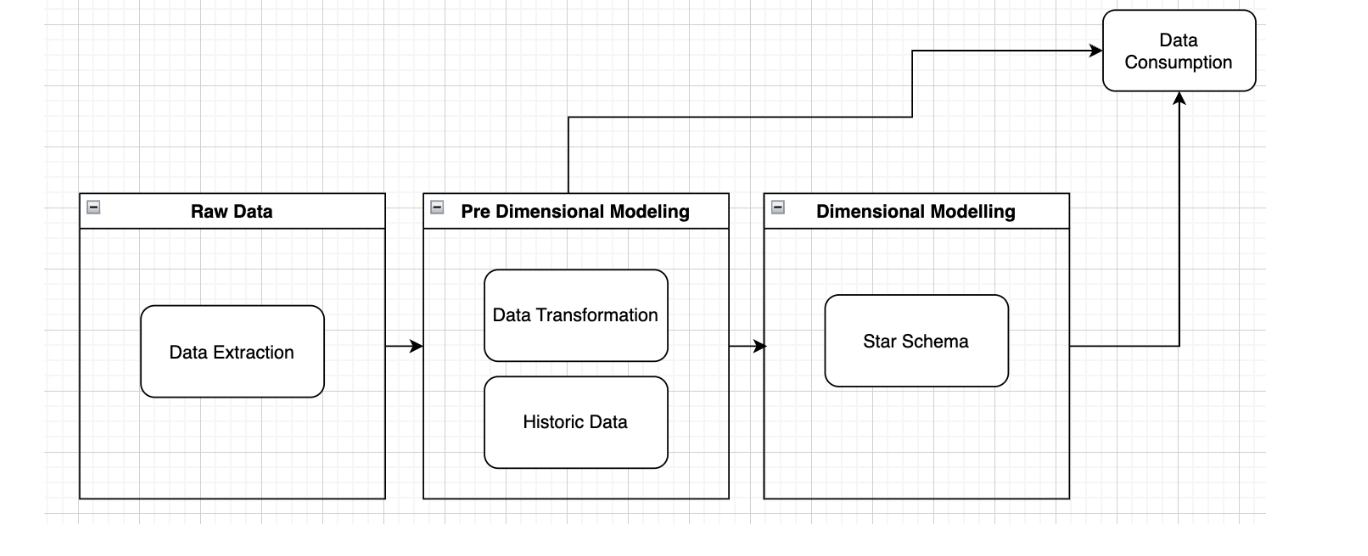

In [153]:
# Create a SQLite database
conn = sqlite3.connect('data_model_star_schema.db')
cursor = conn.cursor()

In [154]:
# Write DataFrame to SQLite table
sales_data.to_sql('sales_data', conn, if_exists='replace', index=False)
products.to_sql('products', conn, if_exists='replace', index=False)
customers.to_sql('customers', conn, if_exists='replace', index=False)

400

In [155]:
import hashlib
def sha1_hash(s):
    return hashlib.sha1(str(s).encode('utf-8')).hexdigest()

#### Step 1: DDL for historic tables

In [156]:
# In this case we use "Create table if not exist to ensure that the tables are created once only during the initial load"

# Create historic  tables
cursor.execute('''
Create table if not exists Hist_Customer (
CustomerID_Hkey Varchar(100),
CustomerID Varchar(100),
Name Varchar(100),
Region Varchar(100),
SignUpDate Timestamp,
Email Varchar(100),
LoyaltyPoints init,
HashDiff Varchar(100),
Load_Date Timestamp,
Load_End_Date Timestamp
    );    
    ''' )


cursor.execute('''
Create table if not exists Hist_Product (
ProductID_Hkey Varchar(100),
ProductID Varchar(100),
ProductName Varchar(100),
Category Varchar(100),
Supplier Varchar(100),
Price init,
HashDiff Varchar(100),
Load_Date Timestamp,
Load_End_Date Timestamp
    );  
  ''')

cursor.execute('''
Create table if not exists Hist_Sales (
SaleID_Hkey Varchar(100),
ProductID_Hkey Varchar(100),
CustomerID_Hkey Varchar(100),
SaleID Varchar(100),
Quantity Integer,
TotalAmount Integer,
SaleDate Timestamp,
Load_Date Timestamp,
Load_End_Date Timestamp
);  
''')

#### Step 2: Transform and load data to Historic tables.
To load data into historic tables, we use the help technical keys. By comparing hashdiff of each hkey, we are able to understan if the record has changed,
is new, is deleted or is modified. Then, by using Load_Date and Load_End_Date we are able to define the period of when the record was active.

For product and customer we follwo exaclty the same logic, for sales_order we have only one small difference: For Historic sales table, we do not use a hashfidd, because we will asume that, if for one sale id, one attribute is changed, the order will be deleted and a new one will be created.

In [ ]:
#CUSTOMER
# The temporary table reads all the data related to details for the source, neccessary transformations are implemented,
#and technical keys are calculated

cursor.execute('''
DROP TABLE IF EXISTS Tmp_Customer  
;
''')

cursor.execute('''
CREATE TEMPORARY TABLE Tmp_Customer AS 
SELECT DISTINCT 
CustomerID AS CustomerID, 
Name AS Name, 
Region AS Region,
SignUpDate AS SignUpDate,
Email AS Email,
LoyaltyPoints AS LoyaltyPoints,
Name||Region||SignUpDate||Email||LoyaltyPoints AS diff,
'{}' AS CustomerID_Hkey, 
'{}' AS HashDiff,
'{}' AS Load_Date,
 '2999-01-01T10:13:29.694+0000' AS Load_End_Date
FROM customers
'''.format(sha1_hash('CustomerID'), sha1_hash('diff'), datetime('now')))

#The purpose of the nexttemporary table is to define the status of the records from the source, as defined
#in the "case when" statement*/
#'N' - /*new record*/
#'E' - /*record already exists*/
#'U' - /*updated customer data*/

cursor.execute('''
DROP TABLE IF EXISTS VW_Customer  
;
''')

cursor.execute(''' 
CREATE TEMPORARY TABLE VW_Customer AS 
SELECT 
tmp.CustomerID,
tmp.Name,
tmp.Region,
tmp.SignUpDate,
tmp.Email,
tmp.LoyaltyPoints,
tmp.CustomerID_Hkey,
tmp.HashDiff,
tmp. Load_Date,
tmp.Load_End_Date,
case 
      when hist.CustomerID_Hkey is Null then 'N' 
      when hist.CustomerID_Hkey is not Null and (hist.HashDiff = tmp.HashDiff) then 'E' 
      when hist.CustomerID_Hkey is not Null and (hist.HashDiff != tmp.HashDiff) then 'U' 
      when tmp.CustomerID_Hkey is Null then 'D' /*record is deleted*/
      END AS Flag_State
 from Tmp_Customer tmp
left join Hist_Customer hist on hist.CustomerID_Hkey = tmp.CustomerID_Hkey
''')

#Insert new data
cursor.execute(''' 
INSERT INTO Hist_Customer 
select CustomerID_Hkey, CustomerID, Name, Region, SignUpDate, Email, LoyaltyPoints, HashDiff, Load_Date, Load_End_Date from  VW_Customer
where Flag_State = 'N'
;
''')

#Update Load_End_Data for deleted data
cursor.execute(''' 
UPDATE Hist_Customer
SET LOAD_END_DATE = datetime('now')
WHERE CustomerID_Hkey in (
select CustomerID_Hkey from  VW_Customer
where Flag_State = 'D')
''')



#Update Load_End_Date for modified data and load the new modified records
cursor.execute(''' 
UPDATE Hist_Customer SET LOAD_END_DATE = datetime('now')
WHERE Load_End_Date = '2999-01-01T10:13:29.694+0000'
And CustomerID_Hkey in (
select CustomerID_Hkey from  VW_Customer
where Flag_State = 'U')
;
''')
 
cursor.execute('''  
INSERT INTO Hist_Customer 
select CustomerID_Hkey, CustomerID, Name, Region, SignUpDate, Email, LoyaltyPoints, HashDiff, Load_Date, Load_End_Date from  VW_Customer
where Flag_State = 'U'
''')


In [ ]:
#Product
# The temporary table reads all the data related to details for the source, neccessary transformations are implemented,
#and technical keys are calculated

cursor.execute('''
DROP TABLE IF EXISTS Tmp_Product  
;
''')

cursor.execute('''
CREATE TEMPORARY TABLE Tmp_Product AS 
SELECT DISTINCT 
ProductID AS ProductID, 
ProductName AS ProductName, 
Category AS Category,
Supplier AS Supplier,
Price AS Price,
ProductName||Category||Supplier||Price AS diff,
'{}' AS ProductID_Hkey, 
'{}' AS HashDiff,
'{}' AS Load_Date,
 '2999-01-01T10:13:29.694+0000' AS Load_End_Date
FROM products
'''.format(sha1_hash('ProductID'), sha1_hash('diff'), datetime('now')))

#The purpose of the nexttemporary table is to define the status of the records from the source, as defined
#in the "case when" statement*/
#'N' - /*new record*/
#'E' - /*record already exists*/
#'U' - /*updated Product data*/

cursor.execute('''
DROP TABLE IF EXISTS VW_Product  
;
''')

cursor.execute(''' 
CREATE TEMPORARY TABLE VW_Product AS 
SELECT 
tmp.ProductID,
tmp.ProductName,
tmp.Category,
tmp.Supplier,
tmp.Price,
tmp.ProductID_Hkey,
tmp.HashDiff,
tmp. Load_Date,
tmp.Load_End_Date,
case 
      when hist.ProductID_Hkey is Null then 'N' 
      when hist.ProductID_Hkey is not Null and (hist.HashDiff = tmp.HashDiff) then 'E' 
      when hist.ProductID_Hkey is not Null and (hist.HashDiff != tmp.HashDiff) then 'U' 
      when tmp.ProductID_Hkey is Null then 'D' /*record is deleted*/
      END AS Flag_State
 from Tmp_Product tmp
left join Hist_Product hist on hist.ProductID_Hkey = tmp.ProductID_Hkey
''')

#Insert new data
cursor.execute(''' 
INSERT INTO Hist_Product 
select ProductID_Hkey, ProductID, ProductName, Category, Supplier, Price, HashDiff, Load_Date, Load_End_Date from  VW_Product
where Flag_State = 'N'
;
''')

#Update Load_End_Data for deleted data
cursor.execute(''' 
UPDATE Hist_Product
SET LOAD_END_DATE = datetime('now') 
WHERE ProductID_Hkey in (
select ProductID_Hkey from  VW_Product
where Flag_State = 'D')
''')



#Update Load_End_Date for modified data and load the new modified records
cursor.execute(''' 
UPDATE Hist_Product SET LOAD_END_DATE = datetime('now')
WHERE Load_End_Date = '2999-01-01T10:13:29.694+0000'
And ProductID_Hkey in (
select ProductID_Hkey from  VW_Product
where Flag_State = 'U')
;
''')
 
cursor.execute('''  
INSERT INTO Hist_Product 
select ProductID_Hkey, ProductID, ProductName, Category, Supplier, Price, HashDiff, Load_Date, Load_End_Date from  VW_Product
where Flag_State = 'U'
''')



In [ ]:



#Sales
#The temporary table reads all the data related to details for the source, neccessary transformations are implemented, and technical keys are calculated

cursor.execute('''
DROP TABLE IF EXISTS Tmp_Sales  
;
''')

cursor.execute('''
CREATE TEMPORARY TABLE Tmp_Sales AS 
SELECT DISTINCT 
SaleID AS SaleID, 
CustomerID AS CustomerID, 
ProductID AS ProductID, 
SaleID AS SaleID,
Quantity AS Quantity,
TotalAmount AS TotalAmount,
SaleDate AS SaleDate,
'{}' AS SaleID_Hkey, 
'{}' AS CustomerID_Hkey,
'{}' AS ProductID_Hkey,
'{}' AS Load_Date,
 '2999-01-01T10:13:29.694+0000' AS Load_End_Date
FROM sales_data
'''.format(sha1_hash('SaleID'), sha1_hash('CustomerID'), sha1_hash('ProductID'), datetime('now')))



# 'N' - new record
# 'D' - record is deleted. There is no such modified sales transaction concept in this case, we only add new sales or delete them
cursor.execute('''
DROP TABLE IF EXISTS VW_Sales  
;
''')

cursor.execute(''' 
CREATE TEMPORARY Table VW_Sales AS 
select 
 tmp.SaleID_Hkey
, tmp.CustomerID_Hkey
, tmp.ProductID_Hkey
, tmp.SaleID
, tmp.Quantity
, tmp.TotalAmount
, tmp.SaleDate
, tmp.Load_Date
, tmp.Load_End_Date
, case 
      when hist.SaleID_Hkey is Null then 'N'
      when tmp.SaleID_Hkey is Null then 'D' 
      END AS Flag_State
 from Tmp_Sales tmp
left join Hist_Sales hist on hist.SaleID_Hkey = tmp.SaleID_Hkey

''')

# Insert new data
cursor.execute(''' 
INSERT INTO Hist_Sales 
select SaleID_Hkey, CustomerID_Hkey, ProductID_Hkey, SaleID, Quantity, TotalAmount, SaleDate, Load_Date, Load_End_Date from  VW_Sales
where Flag_State = 'N'
;
''')
 
# Update Load_End_Data for deleted data
cursor.execute(''' 
UPDATE Hist_Sales SET LOAD_END_DATE = datetime('now')
WHERE SaleID_Hkey in (
select SaleID_Hkey from  VW_Sales
where Flag_State = 'D')
;
''')




#####  Step 3: Load data to dimensional model objects
To load data into dimensional model objects, we filter out non valid records.

In [160]:
# Tables are recreated every data load, as it contains only valid records

cursor.execute(''' 
DROP TABLE IF EXISTS Dim_Customer  
;
''')

cursor.execute(''' 
CREATE  Table Dim_Customer AS 
select 
CustomerID_Hkey,
CustomerID,
Name,
Region,
SignUpDate,
Email,
LoyaltyPoints
from Hist_Customer
where Load_End_Date = '2999-01-01T10:13:29.694+0000'

''')
 
cursor.execute(''' 
DROP TABLE IF EXISTS Dim_Product
;
''')

cursor.execute(''' 
Create Table Dim_Product AS 
Select
ProductID_Hkey,
ProductID,
ProductName,
Category,
Supplier,
Price
from Hist_Product
where Load_End_Date = '2999-01-01T10:13:29.694+0000'

''')

cursor.execute(''' 
Drop Table IF EXISTS F_Sales  
;
''')

cursor.execute(''' 
Create Table F_Sales AS 
select 
SaleID_Hkey,
ProductID_Hkey,
CustomerID_Hkey,
SaleID,
Quantity,
TotalAmount,
SaleDate
from Hist_Sales
where Load_End_Date = '2999-01-01T10:13:29.694+0000'

''')

In [161]:
conn.commit()
conn.close()

In [162]:
# Let's check the results in F_Sales
conn = sqlite3.connect('star_schema.db')
cursor = conn.cursor()

select_query = 'SELECT * FROM F_Sales'
cursor.execute(select_query)

rows = cursor.fetchall()
for row in rows:
    print(row)
    
conn.close()

('17879bd0337ac1e0fba1cdf3f38b319f653ea5b7', '142153cb8e2190a60d1d51e14bebf38b07559b7a', 'bb49eb22d0da68b0f2a387014518a2e7e367eacf', '5083', 9, 1431, '2023-06-19 00:00:00')
('17879bd0337ac1e0fba1cdf3f38b319f653ea5b7', '142153cb8e2190a60d1d51e14bebf38b07559b7a', 'bb49eb22d0da68b0f2a387014518a2e7e367eacf', '6690', 6, 648, '2020-05-15 00:00:00')
('17879bd0337ac1e0fba1cdf3f38b319f653ea5b7', '142153cb8e2190a60d1d51e14bebf38b07559b7a', 'bb49eb22d0da68b0f2a387014518a2e7e367eacf', '8362', 1, 172, '2022-11-03 00:00:00')
('17879bd0337ac1e0fba1cdf3f38b319f653ea5b7', '142153cb8e2190a60d1d51e14bebf38b07559b7a', 'bb49eb22d0da68b0f2a387014518a2e7e367eacf', '6412', 9, 1665, '2023-06-17 00:00:00')
('17879bd0337ac1e0fba1cdf3f38b319f653ea5b7', '142153cb8e2190a60d1d51e14bebf38b07559b7a', 'bb49eb22d0da68b0f2a387014518a2e7e367eacf', '1721', 8, 800, '2022-04-21 00:00:00')
('17879bd0337ac1e0fba1cdf3f38b319f653ea5b7', '142153cb8e2190a60d1d51e14bebf38b07559b7a', 'bb49eb22d0da68b0f2a387014518a2e7e367eacf', '826'